### A starting notebook for the Poisson solver

In this package we seek to solve the Poisson equation on a rectangular domain

In [1]:
using Pkg
Pkg.activate("/Users/jeff/Dropbox/MAE250H/julia/midterm")

"/Users/jeff/Dropbox/MAE250H/julia/midterm/Project.toml"

The usual set of notebooks

In [2]:
using Revise
using Plots
using LinearAlgebra
using FFTW
using project1

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.1/project1/iNSuZ.ji for project1 [69e8fe16-69bc-11e9-02db-a52d5bc2d713]
└ @ Base loading.jl:1184


### Set up the physical problem

In [3]:
LX = 1  # length of x side
x0, y0 = 0.0, 0.0  # coordinates of lower left hand corner of domain

(0.0, 0.0)

#### Set boundary conditions of the problem

In [4]:
uL(y,t) = 0.0
uR(y,t) = 0.0
uB(x,t) = 0.0
uT(x,t) = 1*sin(π*x)

uT (generic function with 1 method)

### Now numerical parameters

In [5]:
NX = 64
NY = 64

64

In [6]:
Δx = LX/NX

0.015625

Pack the parameters into a Parameters type

In [7]:
?ScalarDirichletParameters

search: ScalarDirichletParameters



```
ScalarDirichletParameters(Δx,x0,y0,uL,uR,uB,uT)
```

Set the problem parameters for a scalar-valued problem with Dirichlet boundary conditions


In [8]:
params = ScalarDirichletParameters(Δx,x0,y0,uL,uR,uB,uT)

ScalarDirichletParameters(0.015625, 0.0, 0.0, uL, uR, uB, uT)

### Solve a Dirichlet Poisson problem with Gauss-Seidel

Apply boundary conditions to the solution vector and move these into the RHS

In [9]:
# The solution vector
u = CellData(NX,NY)

# The RHS vector
f = CellData(u);

In [10]:
apply_bc!(u,0,params)
f̃ = Δx^2*f - laplacian(u);

In [11]:
tol = 1e-8

1.0e-8

Set parameters for the G-S scheme

In [12]:
gsparams = RelaxationParameters(apply_dirichlet_bc!,1,"GS")

RelaxationParameters(project1.apply_dirichlet_bc!, 1, "GS")

Now solve

In [13]:
resid_norm = norm(f - laplacian(u))
iter = 0
@time while resid_norm > tol
    global resid_norm = smooth!(u,f̃,gsparams)    
    global iter += 1
end
apply_bc!(u,0,params);
println("Number of iterations = ",iter)
println("Residual norm = ",resid_norm)

  1.246243 seconds (2.45 M allocations: 740.067 MiB, 11.02% gc time)
Number of iterations = 4683
Residual norm = 9.984703472227842e-9


In [14]:
uexact = CellData(u)
ic = indices(uexact,1,interior=false)
jc = indices(uexact,2,interior=false)

for j in jc, i in ic
    x, y = xmap(i,uexact,params),ymap(j,uexact,params)

    uexact[i,j] = sin(π*x)*sinh(π*y)/sinh(π)
end

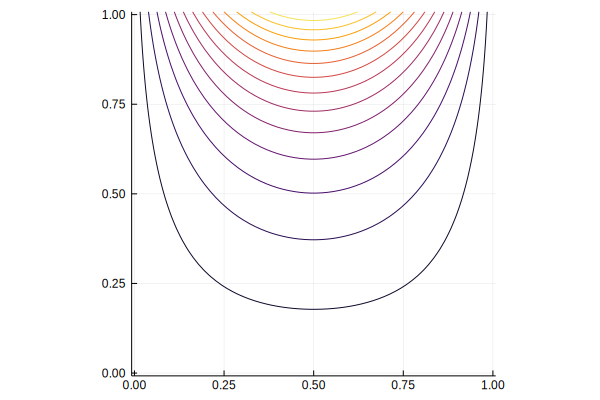

In [15]:
ic = indices(u,1,interior=false)
jc = indices(u,2,interior=false)
contour(xmap(ic,u,params),ymap(jc,u,params),transpose(u[ic,jc]),legend=false,ratio=1)

In [16]:
norm(u-uexact)/norm(uexact)

0.00022793016501875975

### Solve with multigrid

Apply boundary conditions to the solution vector and move these into the RHS

In [17]:
# The solution vector
u = CellData(NX,NY)

# The RHS vector
f = CellData(u);

In [18]:
apply_bc!(u,0,params)
f̃ = Δx^2*f - laplacian(u)
fill!(u,0.0);

In [19]:
?MGParameters

search: MGParameters



```
MGParameters
```

Set parameters for multigrid solution.

# Constructors

  * `MGParameters(apply_bc!,niteri,niter1,niter2,niterf,maxlev,gstol,gsmaxiter,maxcycle,tol)`


In [24]:
maxlev = floor(log2(NX))
mgparams = MGParameters(apply_dirichlet_bc!,1,1,1,1,maxlev,1e-14,10000,1000,1e-7)

MGParameters(project1.apply_dirichlet_bc!, 1, 1, 1, 1, 6, 1.0e-14, 10000, 1000, 1.0e-7)

In [25]:
?mg!

search: mg! merge! mgcycle!



```
mg!(u::ScalarData,f::ScalarData,p::MGParameters) -> Float64
```

Uses multigrid to solve the Poisson system Lu = f, with the right-hand side `f` and initial guess `u`, and multigrid parameters provided in `p`. The function returns the final solution `u` in place. It also returns the final residual norm.


In [26]:
@time resid_norm = mg!(u,f̃,mgparams)
println("Residual norm = ",resid_norm)
apply_bc!(u,0.0,params);

  0.046060 seconds (98.02 k allocations: 48.413 MiB, 34.12% gc time)
Residual norm = 9.502290463909307e-8


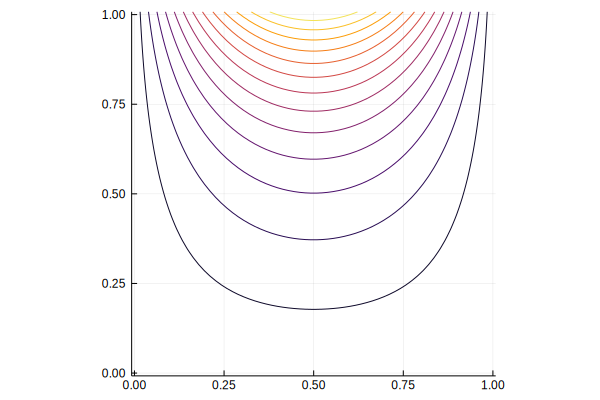

In [27]:
ic = indices(u,1,interior=false)
jc = indices(u,2,interior=false)
contour(xmap(ic,u,params),ymap(jc,u,params),transpose(u[ic,jc]),legend=false,ratio=1)

In [28]:
norm(u-uexact)/norm(uexact)

0.0002208910918087389

### Now solve a Neumann problem with multigrid

In [29]:
# The solution vector
u = CellData(NX,NY)

P = 3
Q = 2

f = CellData(u)
uexact = CellData(u)
ic = indices(f,1,interior=false)
jc = indices(f,2,interior=false)

for j in jc, i in ic
    x, y = xmap(i,uexact,params),ymap(j,uexact,params)

    f[i,j] = cos(P*π*x)*cos(Q*π*y)
    uexact[i,j] = cos(P*π*x)*cos(Q*π*y)
end
uexact .= -f/π^2/(P^2+Q^2);

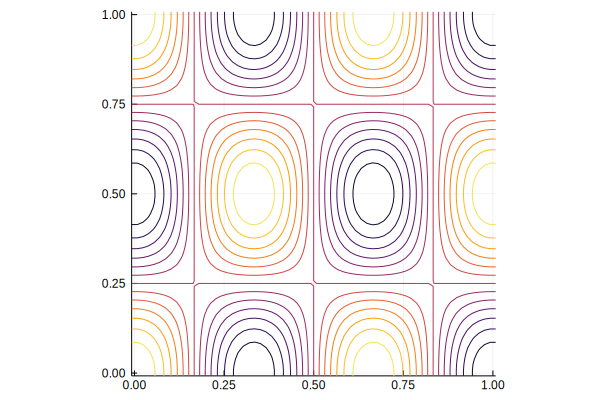

In [30]:
contour(xmap(ic,u,params),ymap(jc,u,params),transpose(f[ic,jc]),legend=false,ratio=1)

In [31]:
u = CellData(NX,NY)
apply_neumann_bc!(u)
f̃ = Δx^2*f - laplacian(u)
fill!(u,0.0);

In [32]:
maxlev = floor(log2(NX))
mgparams = MGParameters(apply_neumann_bc!,1,1,1,1,maxlev,1e-6,10000,1000,1e-7)

MGParameters(project1.apply_neumann_bc!, 1, 1, 1, 1, 6, 1.0e-6, 10000, 1000, 1.0e-7)

In [33]:
@time resid_norm = mg!(u,f̃,mgparams)
println("Residual norm = ",resid_norm)
apply_neumann_bc!(u);

  0.544821 seconds (1.52 M allocations: 95.073 MiB, 5.50% gc time)
Residual norm = 9.776887516182173e-8


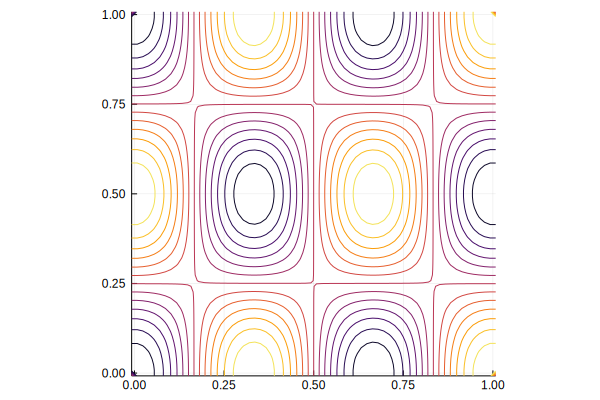

In [34]:
contour(xmap(ic,u,params),ymap(jc,u,params),transpose(u[ic,jc]),legend=false,ratio=1)

In [37]:
norm(u-uexact)/norm(uexact)

0.0014995208913949193

### Now Neumann using discrete cosine transform

In [38]:
u = CellData(NX,NY)
apply_neumann_bc!(u)
f̃ = Δx^2*f - laplacian(u)
u .= f̃
@time poisson_neumann_fft!(u)
norm(u-uexact)/norm(uexact)

  0.000703 seconds (373 allocations: 601.906 KiB)


0.0014995208913949193

### Solve a Dirichlet problem on nodes

In [39]:
uL(y,t) = 0.0
uR(y,t) = 0.0
uB(x,t) = 0.0
uT(x,t) = 0.0
params = ScalarDirichletParameters(Δx,x0,y0,uL,uR,uB,uT)

ScalarDirichletParameters(0.015625, 0.0, 0.0, uL, uR, uB, uT)

In [40]:
# The solution vector
u = NodeData(NX,NY)

P = 3
Q = 1

f = NodeData(u)
uexact = NodeData(u)
i_n = indices(f,1,interior=false)
j_n = indices(f,2,interior=false)

for j in j_n, i in i_n
    x, y = xmap(i,uexact,params),ymap(j,uexact,params)

    f[i,j] = sin(P*π*x)*sin(Q*π*y)
end
uexact .= -f/π^2/(P^2+Q^2);

In [41]:
apply_dirichlet_bc!(u)
f̃ = Δx^2*f - laplacian(u)
fill!(u,0.0);

In [44]:
maxlev = floor(log2(NX))
mgparams = MGParameters(apply_dirichlet_bc!,1,1,1,1,maxlev,1e-6,10000,1000,1e-7)

MGParameters(project1.apply_dirichlet_bc!, 1, 1, 1, 1, 6, 1.0e-6, 10000, 1000, 1.0e-7)

In [45]:
@time resid_norm = mg!(u,f̃,mgparams)
println("Residual norm = ",resid_norm)
apply_dirichlet_bc!(u);

  0.000364 seconds (270 allocations: 435.938 KiB)
Residual norm = 8.643832758910189e-8


In [46]:
norm(u-uexact)/norm(uexact)

0.0022304144503765702